# Классификация эмоциональной составляющей текста
В данном уроке мы будем шаг за шагом строить классификатор для отзывов о фильмах, на самом деле можно построить отзывы для товаров, заведений аналогичным образом, главное получить данные. 

Мы будем работать на базе данных отзывов о фильмах, досупной по ссылке:
http://www.cs.cornell.edu/people/pabo/movie-review-data/

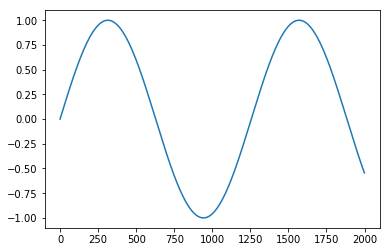

In [571]:
import numpy as np
import codecs
import matplotlib.pyplot as plt
%matplotlib inline 


# def weird_function(x):
#     return (np.sin(0.8*x)+4*np.cos(0.3*x))/5

def weird_function(x):
    return np.sin(0.1*x)

x = np.linspace(0,100,2000)
y = weird_function(x)

plt.plot(y)

In [578]:
class MyRNNCell(nn.Module):
    def __init__(self,n_in,n_hidden,n_out):
        super(MyRNNCell, self).__init__()
        self.hidden = n_hidden
        self.x_update = nn.Linear(n_in+n_hidden,n_out)
        self.hidden_update = nn.Linear(n_in+n_hidden,n_hidden)
    def init_hidden(self):
        return torch.zeros((1,self.hidden))
    def forward(self,x,h):
        combined  = torch.cat([h,x],dim=1)
        newx = F.tanh(self.x_update(combined ))
        newh = F.tanh(self.hidden_update(combined ))
        return newx,newh
    
rnn=MyRNNCell(1,16,1)

timestep = 100./2000.
errors = []
optim = torch.optim.Adam(rnn.parameters(),lr=0.001)
for i in range(5000):
    optim.zero_grad()
    h = rnn.init_hidden()
    seed = np.random.randn(1)*100.    
    for j in range(10):
        x = np.array([seed+j*timestep])
        y_true = weird_function(x)
        y_pred,h = rnn(torch.from_numpy(x).float(),h)       
    loss= F.mse_loss(y_pred,torch.from_numpy(y_true).float())
    loss.backward()
    errors+=[loss.item()]
    optim.step()

plt.plot(errors)

AttributeError: 'Sequence' object has no attribute 'init_hidden'

In [635]:
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [636]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(15):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
plt.savefig('predict%d.pdf'%i)
plt.close()

STEP:  0
loss: 0.502373812248
loss: 0.498566393794
loss: 0.479011960612
loss: 0.446334902148
loss: 0.354063102575
loss: 0.205070166177
loss: 1.39605315612
loss: 0.0324944114847
loss: 0.0299348758396
loss: 0.0283268210115
loss: 0.0268306122188
loss: 0.02377120199
loss: 0.0189014135045
loss: 0.0106468182332
loss: 0.00872575209027
loss: 0.00787218128778
loss: 0.00547784274959
loss: 0.00405193356406
loss: 0.00272962270116
loss: 0.00154026527698
test loss: 0.0013000876157
STEP:  1
loss: 0.00127976461678
loss: 0.00116905549547
loss: 0.00114989160137
loss: 0.00112882452913
loss: 0.0010630561341
loss: 0.000956400644328
loss: 0.000821082758998
loss: 0.000767079602915
loss: 0.000729471642358
loss: 0.000724655816981
loss: 0.000720621139365
loss: 0.000712668605311
loss: 0.000696131049877
loss: 0.000664110181155
loss: 0.000610121070228
loss: 0.000528522838711
loss: 0.000412725071029
loss: 0.000330215794522
loss: 0.00031217121494
loss: 0.000323521922059
test loss: 0.000170051128951
STEP:  2
loss: 0.

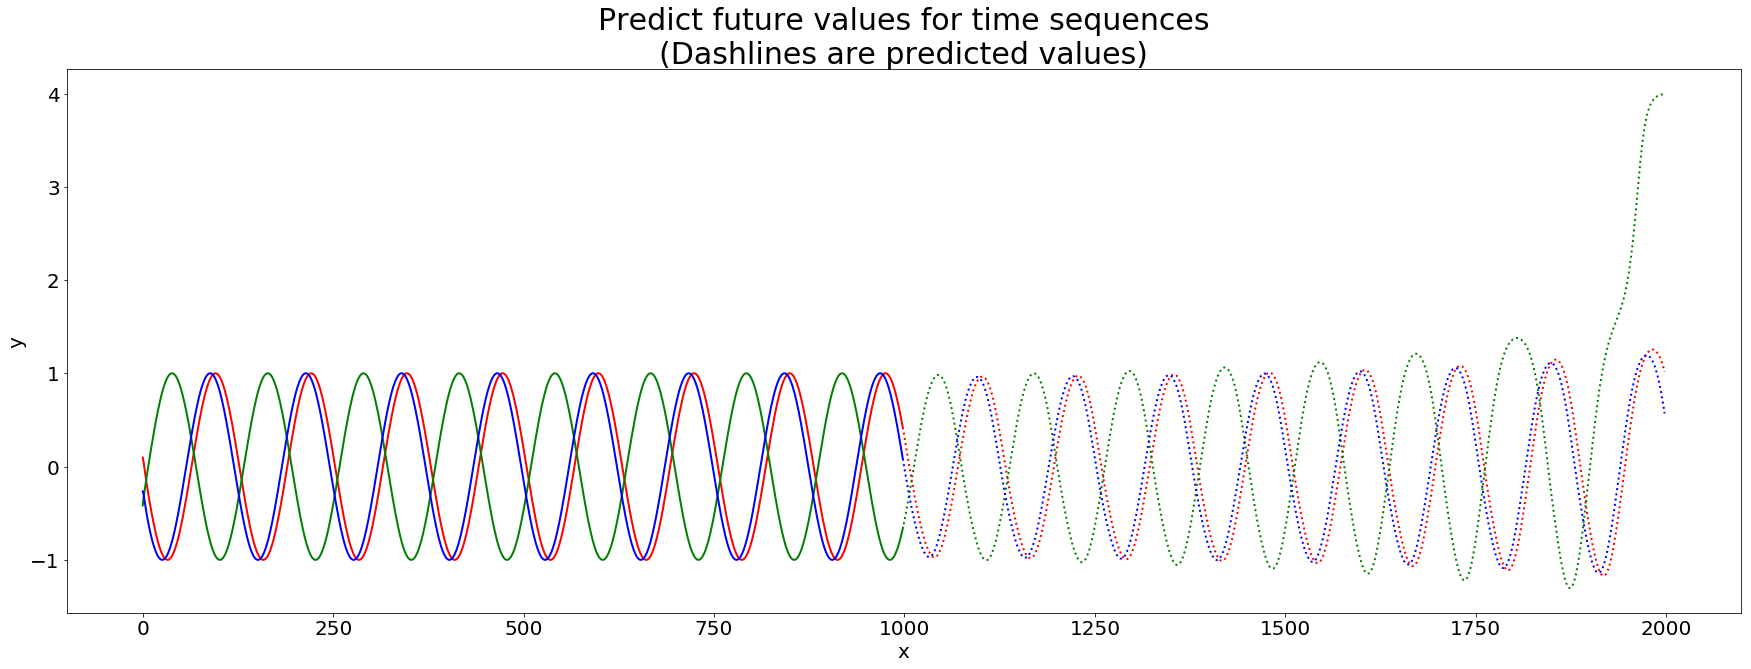

In [639]:
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
#plt.savefig('predict%d.pdf'%i)
#plt.close()

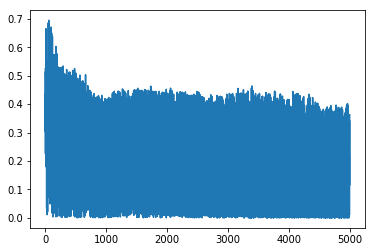

In [630]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.float)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.float)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
    
    
rnn = Sequence()
timestep = 100./2000.
errors = []
optim = torch.optim.Adam(rnn.parameters(),lr=0.0001)
for i in range(5000):
    optim.zero_grad()
    seed = np.random.randint(-100,100)
    l = np.random.randint(10,40)
    x = np.linspace(seed,l*timestep,l)
    y_true = weird_function(x)
    vx = torch.from_numpy(x).unsqueeze(-1).float()
    y_pred = rnn(vx)   
    
    loss= F.mse_loss(y_pred,torch.from_numpy(y_true).unsqueeze(-1).float())
    loss.backward()
    errors+=[loss.item()]
    optim.step()
plt.plot(errors)

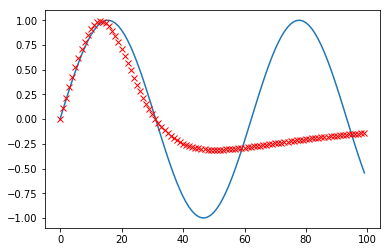

In [633]:
# def weird_function(x):
#     return np.sin(0.8*x)+4*np.cos(0.3*x)

x = np.linspace(0,100,100)
vx = torch.from_numpy(x).unsqueeze(-1).float()
y = weird_function(x)
y_preds = []
y_preds = rnn(vx).detach().numpy()[:,0]   
# for xx in x:
#     h = rnn.init_hidden()
#     inner_x = np.array([[xx]])
#     y_pred,h = rnn(torch.from_numpy(inner_x).float(),h)
#     y_preds.append(y_pred.item())
plt.plot(y)
plt.plot(y_preds,'rx')

In [535]:
inner_x.shape

(1,)

## 1.1 Загрузка и подготовка данных

In [261]:
import numpy as np
import codecs
import matplotlib.pyplot as plt
%matplotlib inline 


pos_string = codecs.open("rt-polarity.pos", encoding="latin-1").read()
neg_string = codecs.open("rt-polarity.neg", encoding="latin-1").read()
symbols = np.frombuffer((pos_string+neg_string).replace('\n',''), dtype="<U1")
unique_symbols = np.unique(symbols)
histogramm = np.array([np.sum(symbols==s) for s in  unique_symbols])
#remove rare symbols
for symbol,nenties in zip(unique_symbols,histogramm):
    if nenties<1000:
        pos_string = pos_string.replace(symbol,'')
        neg_string = neg_string.replace(symbol,'')
        
        
pos_sent = np.array(pos_string.split('\n'))
neg_sent = np.array(neg_string.split('\n'))

#Делаем словарь, для каждого символа свой id
symbol_to_ix = { symbol:index for index,symbol in enumerate(unique_symbols[histogramm>1000])}

In [262]:
symbol_to_ix

{u' ': 0,
 u"'": 1,
 u',': 2,
 u'-': 3,
 u'.': 4,
 u'a': 5,
 u'b': 6,
 u'c': 7,
 u'd': 8,
 u'e': 9,
 u'f': 10,
 u'g': 11,
 u'h': 12,
 u'i': 13,
 u'j': 14,
 u'k': 15,
 u'l': 16,
 u'm': 17,
 u'n': 18,
 u'o': 19,
 u'p': 20,
 u'q': 21,
 u'r': 22,
 u's': 23,
 u't': 24,
 u'u': 25,
 u'v': 26,
 u'w': 27,
 u'x': 28,
 u'y': 29,
 u'z': 30}

In [263]:
indexes = np.random.permutation(len(pos_sent))
train_pos = np.expand_dims(pos_sent[indexes[:-len(indexes)/5]],-1)
valid_pos = np.expand_dims(pos_sent[indexes[-len(indexes)/5:-len(indexes)/10]],-1)
test_pos = np.expand_dims(pos_sent[indexes[-len(indexes)/10:]],-1)

indexes = np.random.permutation(len(neg_sent))
train_neg = np.expand_dims(neg_sent[indexes[:-len(indexes)/5]],-1)
valid_neg = np.expand_dims(neg_sent[indexes[-len(indexes)/5:-len(indexes)/10]],-1)
test_neg= np.expand_dims(neg_sent[indexes[-len(indexes)/10:]],-1)

train = np.concatenate((np.concatenate((train_pos,np.ones(train_pos.shape)),axis=1),
                       np.concatenate((train_neg,np.zeros(train_neg.shape)),axis=1)),axis=0)
valid = np.concatenate((np.concatenate((valid_pos,np.ones(valid_pos.shape)),axis=1),
                       np.concatenate((valid_neg,np.zeros(valid_neg.shape)),axis=1)),axis=0)
test = np.concatenate((np.concatenate((test_pos,np.ones(test_pos.shape)),axis=1),
                       np.concatenate((test_neg,np.zeros(test_neg.shape)),axis=1)),axis=0)

In [264]:
import torch

n_letters = len(symbol_to_ix)
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][symbol_to_ix[letter]] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][symbol_to_ix[letter]] = 1
    return tensor

## 1.2 Посимвольное предсказание

In [259]:
voc = np.array([str(i) for i in range(10)])
pos = np.sort(np.random.randint(0,len(voc),np.random.randint(2,7)))
neg = np.sort(np.random.randint(0,len(voc),np.random.randint(2,7)))[::-1]
 
symbol_to_ix ={ symbol:index for index,symbol in enumerate(voc)}
n_letters = len(symbol_to_ix)

In [260]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        return (torch.zeros(1, self.batch_size, self.n_neurons)).to(device)
        
    def forward(self, X):        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs)
    
    


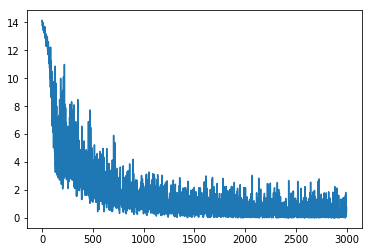

In [224]:
import torch.nn.functional as F
model = RNN(1,3,10,32,1).to(device)
criterion = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(),lr =0.001)
error = []
for i in range(3000):
    optim.zero_grad()
    vloss = 0.
    for j in range(20):
        sample = np.sort(np.random.randint(0,len(voc),np.random.randint(2,7)))
        y_gt = torch.FloatTensor([1.]).to(device)
        if np.random.randint(0,2)==0:
            sample = sample[::-1]
            y_gt[0]=0.


        data = lineToTensor(voc[sample]).to(device)
        y_prob = F.sigmoid(model(data))
        loss = criterion(y_prob.squeeze(),y_gt.detach())
        vloss+=loss.item()
        loss.backward()
    error+=[vloss]
    optim.step()
    
plt.plot(error)

In [258]:
#Проверка точности нашего метода
nerrors = 0.
for i in range(1000):
    sample = np.sort(np.random.randint(0,len(voc),np.random.randint(2,7)))
    y_gt = torch.FloatTensor([1.]).to(device)
    if np.random.randint(0,2)==0:
        sample = sample[::-1]
        y_gt[0]=0.
    data = lineToTensor(voc[sample]).to(device)
    y_prob = F.sigmoid(model(data))
    if abs(y_prob.item()-y_gt.item())>0.5:
        nerrors+=1

#Процент ошибок
print(nerrors/10.,'%')

(0.8, '%')


In [ ]:
model = RNN(1,1,len(symbol_to_ix),64,1).to(device)
criterion = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(),lr =0.001)
error = []
for i in range(1000):
    optim.zero_grad()
    vloss = 0.
    for j in range(1000):
        str_id = np.random.randint(0,high=len(train))

        x,y = train[str_id]
        if len(x)<1:
            continue
        y_gt = torch.FloatTensor([float(y)]).to(device)
        data = lineToTensor(x).to(device)
        y_prob = F.sigmoid(model(data))
        loss = criterion(y_prob.squeeze(),y_gt.detach())
        loss.backward()
        vloss+=loss.item()    
    error+=[vloss/1000.]
    optim.step()
plt.plot(error)    

In [296]:
nerrors = 0.
for i in range(100):
    str_id = np.random.randint(0,high=len(train))
    x,y = train[str_id]
    if len(x)<1:
        continue  
    if np.random.randint(0,2)==0:
        sample = sample[::-1]
        y_gt[0]=0.
    data = lineToTensor(x).to(device)
    y_prob = F.sigmoid(model(data))
    if abs(y_prob.item()-float(y))>0.5:
        nerrors+=1

#Процент ошибок
print(nerrors,'%')

(45.0, '%')


## 2.1 Слово в вектор Word2Vec

In [357]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 128

trigrams = [] 

allwords = []
for sentence in [t.split(' ') for t in train[:,0]]:
    allwords += sentence
    trigrams += [([sentence[i], sentence[i + 1]], sentence[i + 2]) for i in range(len(sentence) - 2)]
print(trigrams[:3])

[([u'though', u'intrepid'], u'in'), ([u'intrepid', u'in'], u'exploring'), ([u'in', u'exploring'], u'an')]


In [358]:
vocab = set(allwords)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [359]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

losses = []
criterion = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long).to(device)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = criterion(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long).to(device))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    print(losses[-1])  # The loss decreased every iteration over the training data!

1104792.62477
1015883.48683
963195.764567
918863.616033
878791.522684
842076.687707
809031.575348
779632.03023
754140.827156
731857.505697
712536.208529
695532.393351
680191.669497
666286.798707
653855.756993
642370.171165
631641.066172
621620.940756
612245.409976
603287.445295


In [362]:
context_idxs = torch.tensor([word_to_ix['in']], dtype=torch.long).to(device)
model.embeddings(context_idxs)

tensor([[-0.7800, -0.4422,  0.0548,  0.2469,  0.3710,  0.5234,  0.1251,
         -0.6669, -0.6034, -1.8300, -0.8322, -0.0738, -0.4709,  0.6956,
          0.1690, -0.6687,  0.4755, -0.8827, -0.1272, -0.2785, -0.5269,
         -0.6621,  0.6914, -0.1288, -0.0428,  1.4117, -0.9332,  0.2234,
         -0.1741, -0.4078, -0.4379, -0.2153, -0.4976, -0.4702, -0.8839,
          0.0569, -0.3318, -0.6060, -0.2649,  0.0733, -0.2427,  0.4692,
          0.7338, -0.2858, -1.6466, -0.2103,  0.1120,  1.1988, -0.1027,
          0.2029,  0.1256, -0.3531,  0.6077,  0.4860,  0.4121, -0.7126,
          0.5661,  1.0021,  0.6960,  0.0076, -0.7070, -0.4630,  0.1674,
          0.4141, -0.2194, -0.3413, -0.4018, -0.0983,  0.1886, -0.4833,
          1.1067,  0.3666, -0.9204, -1.0831,  0.3038,  0.7039, -1.2835,
          0.8693,  0.5901,  0.3375, -0.6859,  0.2626, -0.2640,  0.7391,
          0.0417, -0.6760, -0.9437,  0.3515, -0.5208,  0.1965, -0.3919,
         -1.2678, -0.2432,  0.0294, -0.2162, -0.3334, -0.5278,  

## 3.1 Использование Word2Vec для предсказания по словам

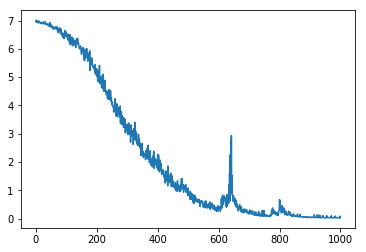

In [372]:
import torch.nn.functional as F
rnn = RNN(1,1,EMBEDDING_DIM,64,1).to(device)
criterion = torch.nn.BCELoss()
optim = torch.optim.Adam(rnn.parameters(),lr =0.001)
error = []
for i in range(1000):
    optim.zero_grad()
    vloss = 0.
    for j in range(1000):
        str_id = np.random.randint(0,high=len(train))
        x,y = train[str_id]
        context_idxs = torch.tensor([word_to_ix[w] for w in x.split(' ')], dtype=torch.long).to(device)
        
        data =  model.embeddings(context_idxs).unsqueeze(1).detach()
        y_gt = torch.FloatTensor([float(y)]).to(device)
        y_prob = F.sigmoid(rnn(data))
        loss = criterion(y_prob.squeeze(),y_gt.detach())
        loss.backward()
        vloss+=loss.item()    
    error+=[vloss/100.]
    #print(error[-1])
    optim.step()
    
plt.plot(error)

Когда мы обучили нашу модель, мы пожем измерить точность классификации фразы

In [488]:
error=0 #Количество ошибок
for i in range(100):
    str_id = np.random.randint(0,high=len(test))
    x,y = test[str_id]
    #Выкидываем слова, не попавшие в наш словарь
    indexes = [word_to_ix[w] for w in x.split(' ') if w in word_to_ix.keys()]
    context_idxs = torch.tensor(indexes, dtype=torch.long).to(device)
    data =  model.embeddings(context_idxs).unsqueeze(1).detach()
    y_prob = F.sigmoid(rnn(data))
    if abs(y_prob.item()-float(y))>0.5:
        error+=1


print(error,'%')

(27, '%')


In [485]:
indexes

[]